<a href="https://colab.research.google.com/github/1hamzaiqbal/MFCLIP_acv/blob/hamza%2Fdiscrim/tsne_clip_features.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# t-SNE Visualization: CLIP Features with Different Loss Functions

This notebook visualizes how different **loss functions** affect the learned CLIP feature space.

**What we're comparing:**
- Vanilla CLIP features (no finetuning)
- ArcFace-trained features
- SigLip-trained features
- ArcFaceSigmoid-trained features

**Key Question:** Do different loss functions produce better class separation?

**Expected Result:** ArcFace and similar metric learning losses should produce tighter, more separated clusters.

In [1]:
# Cell 1: GPU + Repo Setup
!nvidia-smi
%cd /content

import os
if not os.path.exists("MFCLIP_acv"):
    !git clone -b hamza/discrim https://github.com/1hamzaiqbal/MFCLIP_acv

%cd MFCLIP_acv
!git fetch --all
!git reset --hard origin/hamza/discrim

Mon Dec  1 08:30:55 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA L4                      Off |   00000000:00:03.0 Off |                    0 |
| N/A   32C    P8             11W /   72W |       0MiB /  23034MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
# Cell 2: Install Dependencies
!pip install -q torch torchvision timm einops yacs tqdm opencv-python scikit-learn scipy pyyaml ruamel.yaml pytorch-ignite foolbox pandas matplotlib seaborn wilds ftfy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.9/119.9 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 343.8/343.8 kB 20.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 61.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.2/126.2 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.8/78.8 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 788.2/788.2 kB 53.2 MB/s eta 0:00:00


In [3]:
# Cell 3: Download Oxford Pets Dataset
from torchvision.datasets import OxfordIIITPet
from torchvision import transforms
from pathlib import Path
import os

root = Path("/content/data/oxford_pets")
root.mkdir(parents=True, exist_ok=True)
_ = OxfordIIITPet(root=str(root), download=True, transform=transforms.ToTensor())
print("Oxford Pets downloaded")

%cd /content
if not os.path.exists("/content/data/oxford_pets/images"):
    print("Downloading images and annotations...")
    !wget -q https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
    !wget -q https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
    !tar -xf images.tar.gz -C /content/data/oxford_pets
    !tar -xf annotations.tar.gz -C /content/data/oxford_pets
    !rm -f images.tar.gz annotations.tar.gz
print("Dataset ready!")

100%|██████████| 792M/792M [00:35<00:00, 22.3MB/s]
100%|██████████| 19.2M/19.2M [00:01<00:00, 11.6MB/s]


Oxford Pets downloaded
/content
Dataset ready!


In [4]:
# Cell 4: Mount Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

DRIVE_ROOT = "/content/drive/MyDrive/grad/comp_vision/hanson_loss/oxford_pets"

print("\nAvailable checkpoints in Drive:")
if os.path.exists(DRIVE_ROOT):
    for f in sorted(os.listdir(DRIVE_ROOT)):
        if f.endswith('.pth') or f.endswith('.pt'):
            size_mb = os.path.getsize(f"{DRIVE_ROOT}/{f}") / 1e6
            print(f"  {f} ({size_mb:.1f} MB)")

Mounted at /content/drive

Available checkpoints in Drive:
  RN50_ArcFace.pth (153.8 MB)
  RN50_ArcFaceSigmoid_100ep.pth (153.8 MB)
  RN50_ArcFaceSigmoid_300ep.pth (153.8 MB)
  RN50_ArcFace_300ep.pth (153.8 MB)
  RN50_ArcFace_food101.pth (154.0 MB)
  RN50_ArcFace_oxford_pets (1).pth (153.8 MB)
  RN50_ArcFace_oxford_pets.pth (153.8 MB)
  RN50_SigLipHead_100ep.pth (153.8 MB)
  RN50_SigLipHead_300ep.pth (153.8 MB)
  hl_RN50_ArcFaceSigmoid.pth (153.8 MB)
  hl_RN50_HingeLossHead.pth (153.8 MB)
  hl_RN50_SigLipHead.pth (153.8 MB)
  unet-contrastive-pets.pt (7.1 MB)
  unet-vanilla-pets.pt (7.1 MB)
  vit_generator.pt (31.3 MB)
  vit_generator_contrastive.pt (31.3 MB)
  vit_generator_mixed.pt (31.3 MB)
  vit_generator_mixed_loss.pt (31.3 MB)
  vit_generator_targeted_only.pt (31.3 MB)


In [5]:
# Cell 5: Define Checkpoint Paths - EDIT THESE AS NEEDED
CHECKPOINTS = {
    "ArcFace": f"{DRIVE_ROOT}/RN50_ArcFace_oxford_pets.pth",
    "ArcFaceSigmoid": f"{DRIVE_ROOT}/RN50_ArcFaceSigmoid_300ep.pth",
    "SigLip": f"{DRIVE_ROOT}/RN50_SigLipHead_300ep.pth",
}

print("Checkpoint availability:")
available_checkpoints = {}
for name, path in CHECKPOINTS.items():
    if os.path.exists(path):
        print(f"  OK {name}")
        available_checkpoints[name] = path
    else:
        print(f"  MISSING {name}")

Checkpoint availability:
  OK ArcFace
  OK ArcFaceSigmoid
  OK SigLip


In [6]:
# Cell 6: Setup Python Path
import sys
sys.path.insert(0, "/content/MFCLIP_acv/lpclip")
sys.path.insert(0, "/content/MFCLIP_acv")
os.makedirs("/content/MFCLIP_acv/lpclip/datasets", exist_ok=True)
open("/content/MFCLIP_acv/lpclip/datasets/__init__.py", "a").close()
print("Python path configured")

Python path configured


In [7]:
# Cell 7: Extract Vanilla CLIP Features
%cd /content/MFCLIP_acv

DATA = "/content/data"
FEAT_DIR = "/content/MFCLIP_acv/clip_feat"

print("Extracting vanilla CLIP features...")
!python -m lpclip.feat_extractor --split test --root "{DATA}" --seed 1 --dataset-config-file configs/datasets/oxford_pets.yaml --config-file configs/trainers/CoOp/rn50_val.yaml --output-dir "{FEAT_DIR}" --eval-only

print("\nFeature extraction complete!")
!ls -l {FEAT_DIR}/OxfordPets

/content/MFCLIP_acv
Extracting vanilla CLIP features...
***************
** Arguments **
***************
backbone: 
config_file: configs/trainers/CoOp/rn50_val.yaml
dataset_config_file: configs/datasets/oxford_pets.yaml
eval_only: True
head: 
num_shot: 1
output_dir: /content/MFCLIP_acv/clip_feat
root: /content/data
seed: 1
split: test
trainer: 
************
** Config **
************
DATALOADER:
  BS: 128
  K_TRANSFORMS: 1
  NUM_WORKERS: 8
  RETURN_IMG0: False
  TEST:
    BATCH_SIZE: 200
    SAMPLER: SequentialSampler
  TRAIN_U:
    BATCH_SIZE: 32
    N_DOMAIN: 0
    N_INS: 16
    SAME_AS_X: True
    SAMPLER: RandomSampler
  TRAIN_X:
    BATCH_SIZE: 200
    N_DOMAIN: 0
    N_INS: 16
    SAMPLER: RandomSampler
DATASET:
  ALL_AS_UNLABELED: False
  CIFAR_C_LEVEL: 1
  CIFAR_C_TYPE: 
  NAME: OxfordPets
  NUM_LABELED: -1
  NUM_SHOTS: -1
  ROOT: /content/data
  SOURCE_DOMAINS: ()
  STL10_FOLD: -1
  SUBSAMPLE_CLASSES: all
  TARGET_DOMAINS: ()
  VAL_PERCENT: 0.1
INPUT:
  COLORJITTER_B: 0.4
  COLO

In [8]:
# Cell 8: Define t-SNE Helper Functions
import numpy as np
import matplotlib.pyplot as plt
import torch
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import pdist

FEAT_DIR = "/content/MFCLIP_acv/clip_feat/OxfordPets"
OUT_DIR = "/content/MFCLIP_acv/tsne_results"
os.makedirs(OUT_DIR, exist_ok=True)

def load_npz(split="test"):
    d = np.load(os.path.join(FEAT_DIR, f"{split}.npz"))
    return d["feature_list"].astype(np.float32), d["label_list"].astype(np.int64)

def torch_load_any(path):
    sd = torch.load(path, map_location="cpu")
    return sd["state_dict"] if isinstance(sd, dict) and "state_dict" in sd else sd

def guess_head_weight(sd, in_dim):
    cands = [(k,v) for k,v in sd.items() if isinstance(v, torch.Tensor) and v.ndim==2]
    for k,v in cands:
        if v.shape[0] == in_dim:
            return v.numpy(), k
    return None, None

def cosine_project(X, W):
    Xn = X / np.maximum(np.linalg.norm(X, axis=1, keepdims=True), 1e-12)
    Wn = W / np.maximum(np.linalg.norm(W, axis=0, keepdims=True), 1e-12)
    return Xn @ Wn

def run_single_tsne(X, y, title, perplexity=30):
    print(f"Running t-SNE for: {title}...")
    Z = TSNE(n_components=2, perplexity=perplexity, random_state=42, init="pca", n_iter=1000).fit_transform(X)
    try:
        sil = silhouette_score(Z, y)
    except:
        sil = np.nan
    return Z, sil

print("Helper functions defined")

Helper functions defined


In [9]:
# Cell 9: Run t-SNE on All Variants
X_vanilla, y = load_npz("test")
print(f"Loaded {len(X_vanilla)} samples with {len(np.unique(y))} classes")
print(f"Feature dim: {X_vanilla.shape[1]}")

all_results = {}

# Vanilla CLIP
Z_vanilla, sil_vanilla = run_single_tsne(X_vanilla, y, "Vanilla CLIP")
all_results["Vanilla CLIP"] = {"embeddings": Z_vanilla, "silhouette": sil_vanilla, "features": X_vanilla}

# Process each checkpoint
for name, path in available_checkpoints.items():
    print(f"\n--- Processing {name} ---")
    sd = torch_load_any(path)
    W, key = guess_head_weight(sd, X_vanilla.shape[1])

    if W is not None:
        print(f"  Using weight: {key} {W.shape}")
        X_proj = cosine_project(X_vanilla, W)
        Z, sil = run_single_tsne(X_proj, y, name)
        all_results[name] = {"embeddings": Z, "silhouette": sil, "features": X_proj}
    else:
        print(f"  Could not find projection weights")

print(f"\nProcessed {len(all_results)} variants")

Loaded 3669 samples with 37 classes
Feature dim: 1024
Running t-SNE for: Vanilla CLIP...


/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(



--- Processing ArcFace ---
  Using weight: backbone.1.attnpool.c_proj.weight (1024, 2048)
Running t-SNE for: ArcFace...


/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(



--- Processing ArcFaceSigmoid ---
  Using weight: backbone.1.attnpool.c_proj.weight (1024, 2048)
Running t-SNE for: ArcFaceSigmoid...


/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(



--- Processing SigLip ---
  Using weight: backbone.1.attnpool.c_proj.weight (1024, 2048)
Running t-SNE for: SigLip...


/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(



Processed 4 variants


/tmp/ipython-input-4106555126.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab20', len(np.unique(y)))


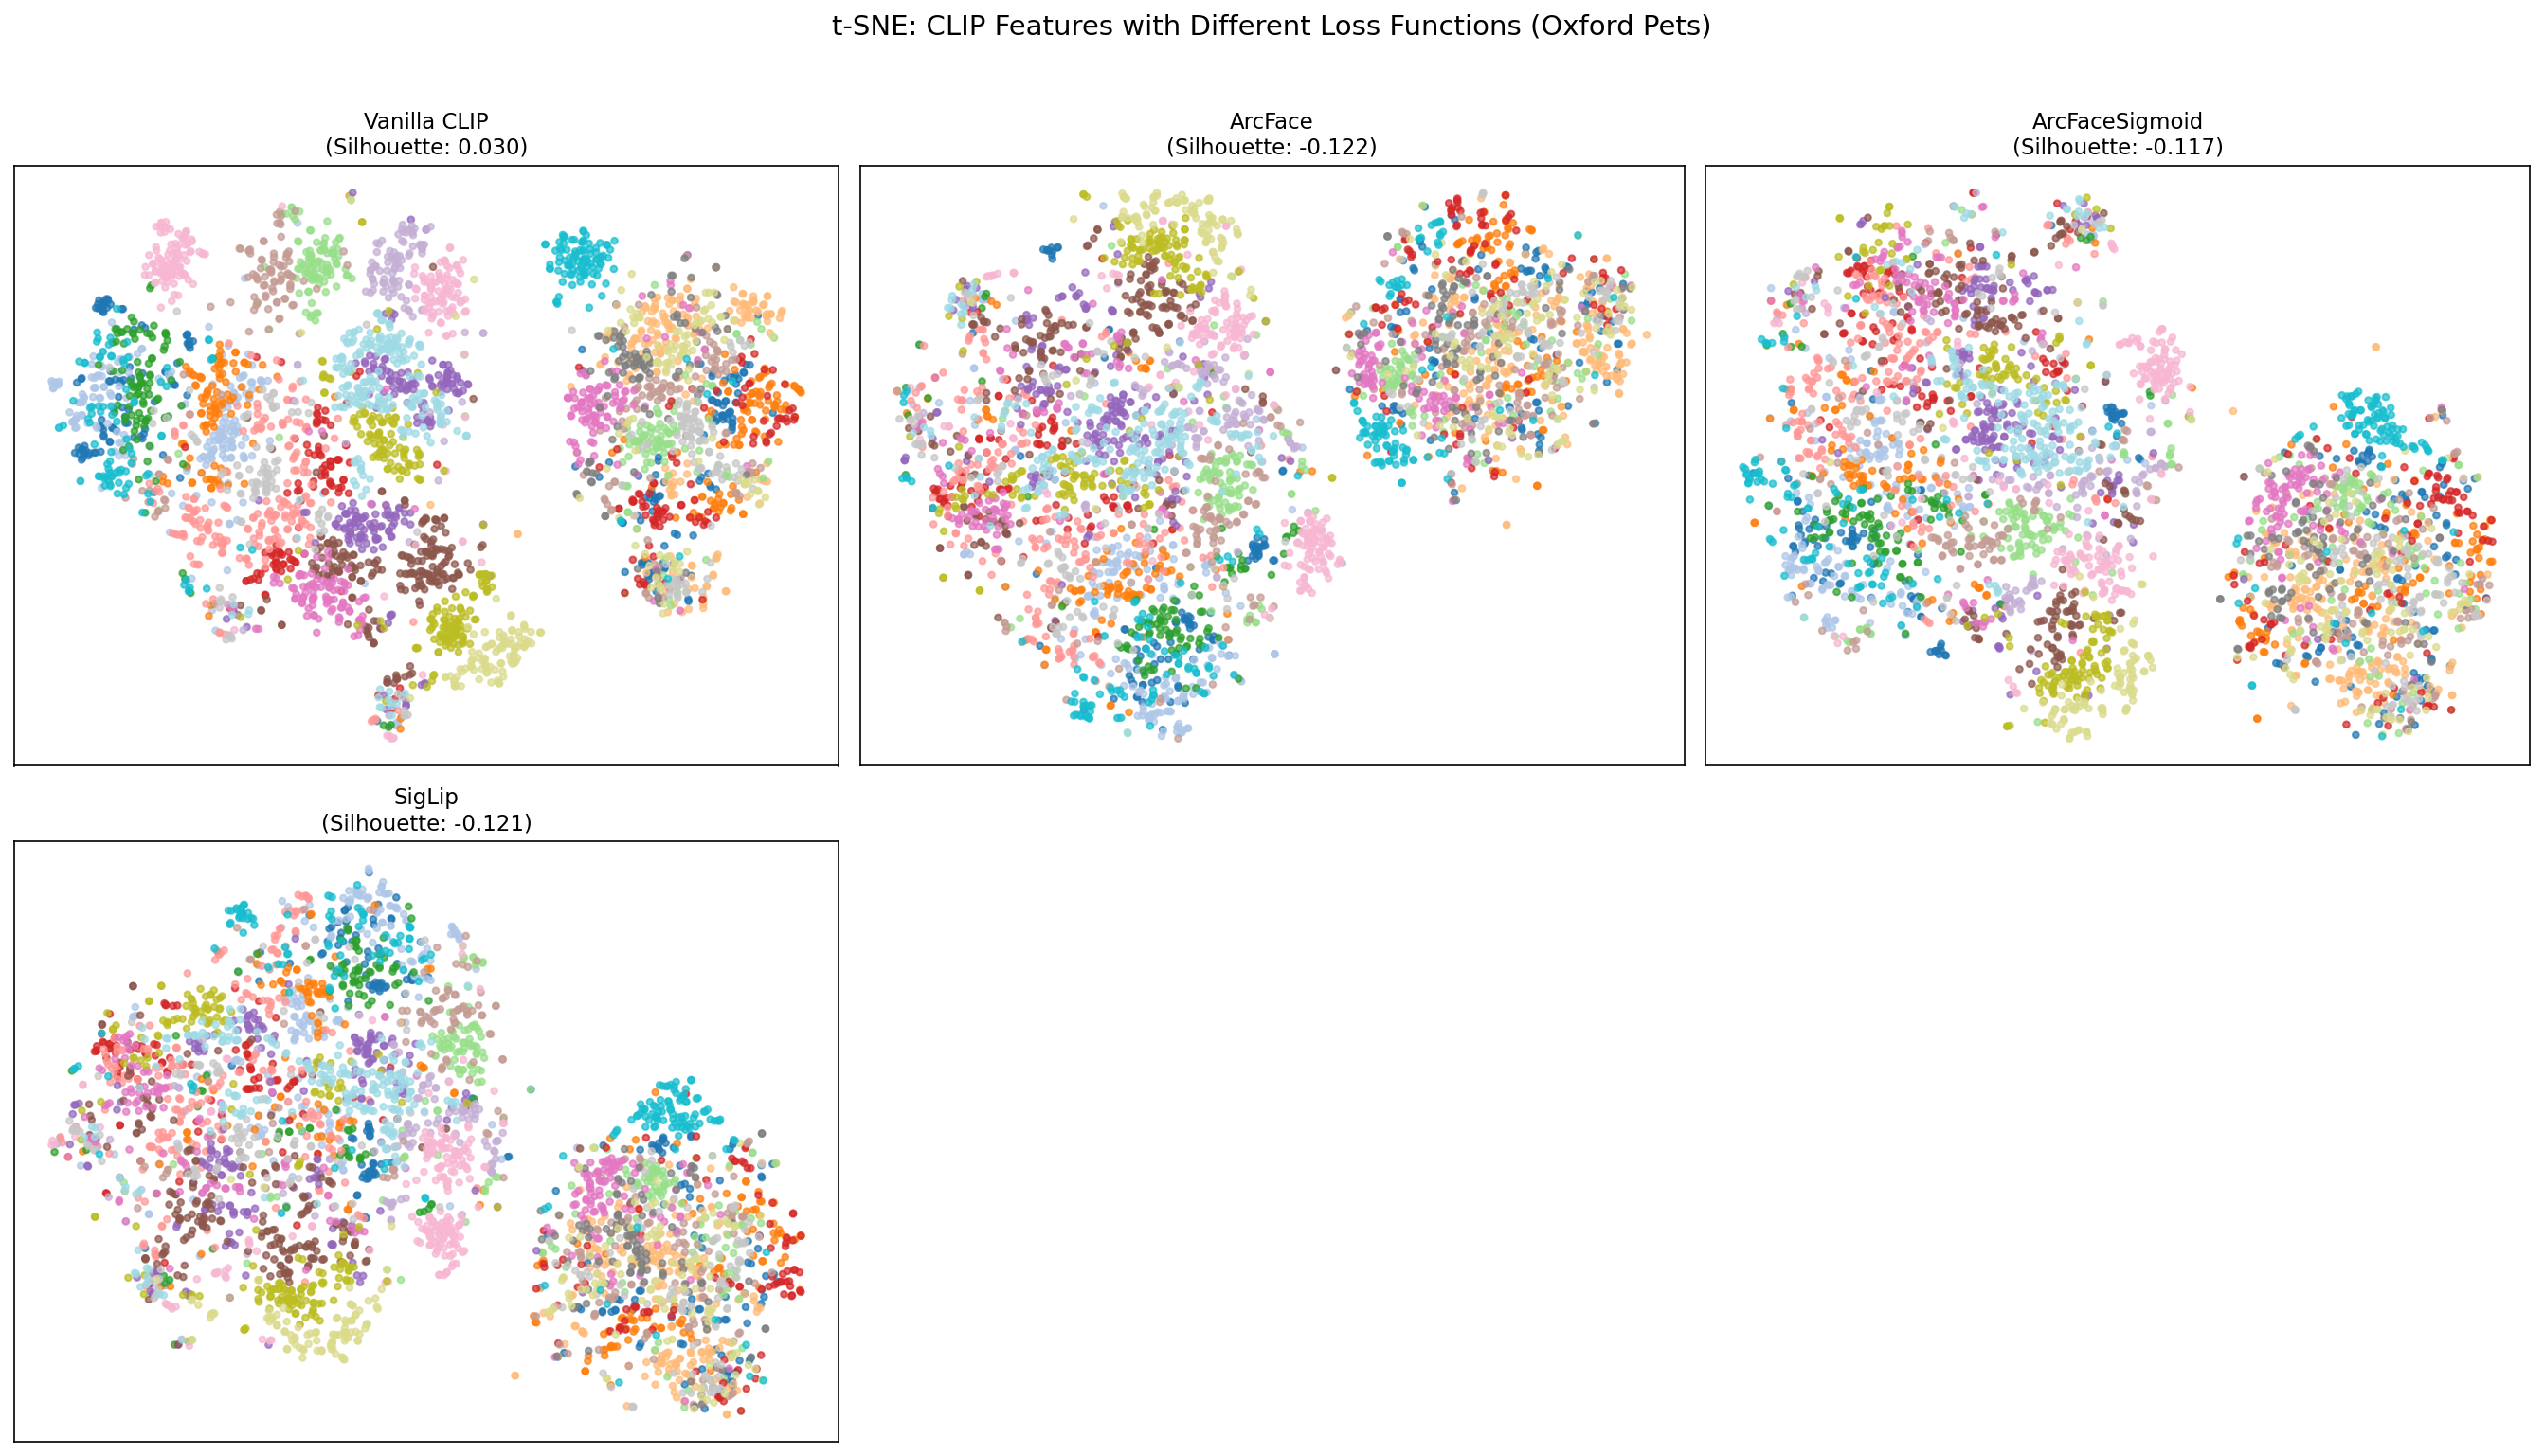


Saved to /content/MFCLIP_acv/tsne_results/tsne_loss_comparison.png


In [10]:
# Cell 10: Visualize All Variants Side-by-Side
n_variants = len(all_results)
cols = min(n_variants, 3)
rows = (n_variants + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(6*cols, 5*rows), dpi=150)
if n_variants == 1:
    axes = np.array([axes])
axes = axes.flatten()

cmap = plt.cm.get_cmap('tab20', len(np.unique(y)))

for idx, (name, data) in enumerate(all_results.items()):
    ax = axes[idx]
    Z = data["embeddings"]
    sil = data["silhouette"]
    scatter = ax.scatter(Z[:, 0], Z[:, 1], c=y, s=10, alpha=0.7, cmap=cmap)
    ax.set_title(f"{name}\n(Silhouette: {sil:.3f})", fontsize=11)
    ax.set_xticks([])
    ax.set_yticks([])

for idx in range(n_variants, len(axes)):
    axes[idx].axis('off')

plt.suptitle("t-SNE: CLIP Features with Different Loss Functions (Oxford Pets)", fontsize=14, y=1.02)
plt.tight_layout()
plt.savefig(f"{OUT_DIR}/tsne_loss_comparison.png", dpi=150, bbox_inches='tight')
plt.show()
print(f"\nSaved to {OUT_DIR}/tsne_loss_comparison.png")

In [11]:
# Cell 11: Quantitative Metrics Summary
import pandas as pd

def compute_distance_metrics(X, y):
    classes = np.unique(y)
    intra_dists = []
    for c in classes:
        mask = (y == c)
        if mask.sum() > 1:
            X_c = X[mask]
            dists = pdist(X_c, 'cosine')
            if len(dists) > 0:
                intra_dists.append(np.mean(dists))
    centroids = np.array([X[y == c].mean(axis=0) for c in classes])
    inter_dists = pdist(centroids, 'cosine')
    return np.mean(intra_dists) if intra_dists else np.nan, np.mean(inter_dists)

results_table = []
for name, data in all_results.items():
    intra, inter = compute_distance_metrics(data["features"], y)
    results_table.append({
        "Loss Function": name,
        "Silhouette Score": data["silhouette"],
        "Intra-class Dist": intra,
        "Inter-class Dist": inter,
        "Ratio (inter/intra)": inter / intra if intra > 0 else np.nan
    })

df = pd.DataFrame(results_table)
df = df.sort_values("Silhouette Score", ascending=False)

print("=" * 70)
print("CLIP Feature Quality Metrics (by Loss Function)")
print("=" * 70)
print(df.to_string(index=False))
print("=" * 70)
print("\nHigher Silhouette Score = better cluster separation")

CLIP Feature Quality Metrics (by Loss Function)
 Loss Function  Silhouette Score  Intra-class Dist  Inter-class Dist  Ratio (inter/intra)
  Vanilla CLIP          0.029613          0.196951          0.126443             0.642005
ArcFaceSigmoid         -0.117153          0.136969          0.067342             0.491657
        SigLip         -0.121405          0.154046          0.076149             0.494325
       ArcFace         -0.122377          0.096814          0.046242             0.477631

Higher Silhouette Score = better cluster separation


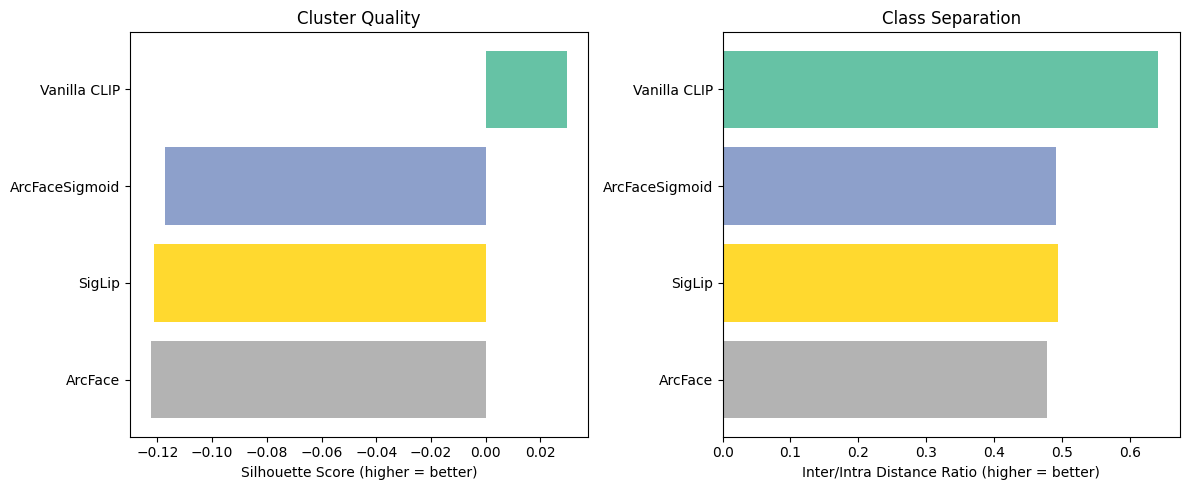

In [12]:
# Cell 12: Plot Metrics Bar Chart
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

names = df["Loss Function"].tolist()
colors = plt.cm.Set2(np.linspace(0, 1, len(names)))

ax = axes[0]
bars = ax.barh(names, df["Silhouette Score"], color=colors)
ax.set_xlabel("Silhouette Score (higher = better)")
ax.set_title("Cluster Quality")
ax.invert_yaxis()

ax = axes[1]
bars = ax.barh(names, df["Ratio (inter/intra)"], color=colors)
ax.set_xlabel("Inter/Intra Distance Ratio (higher = better)")
ax.set_title("Class Separation")
ax.invert_yaxis()

plt.tight_layout()
plt.savefig(f"{OUT_DIR}/metrics_comparison.png", dpi=150, bbox_inches='tight')
plt.show()

In [13]:
# Cell 13: Save Results to Google Drive
import shutil

SAVE_DIR = f"{DRIVE_ROOT}/tsne_clip_features"
os.makedirs(SAVE_DIR, exist_ok=True)

files_to_save = [
    f"{OUT_DIR}/tsne_loss_comparison.png",
    f"{OUT_DIR}/metrics_comparison.png",
]

print(f"Saving results to {SAVE_DIR}...")
for f in files_to_save:
    if os.path.exists(f):
        shutil.copy(f, SAVE_DIR)
        print(f"  OK {os.path.basename(f)}")

df.to_csv(f"{SAVE_DIR}/clip_feature_metrics.csv", index=False)
print(f"  OK clip_feature_metrics.csv")
print(f"\nAll results saved to {SAVE_DIR}")

Saving results to /content/drive/MyDrive/grad/comp_vision/hanson_loss/oxford_pets/tsne_clip_features...
  OK tsne_loss_comparison.png
  OK metrics_comparison.png
  OK clip_feature_metrics.csv

All results saved to /content/drive/MyDrive/grad/comp_vision/hanson_loss/oxford_pets/tsne_clip_features
